In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("white")

sc.settings.verbosity=3

In [3]:
import os, sys
sys.path.append(f"{os.getcwd()}/../code")
from plotting.plot_settings import *
from plotting.palettes import *

In [4]:
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist

In [5]:
data_dir = Path(f"{os.getcwd()}/../data")
fig_dir = Path(f"{os.getcwd()}/../figures")

## Create a common AnnData object containing both bulk and single cell pseudobulk

In [6]:
bulk_file = data_dir / "bulk.txt"
pseudobulk_file = data_dir / "pseudobulk.txt"
metadata_file = data_dir / "pseudobulk-metadata.txt"

In [7]:
bulk = pd.read_table(bulk_file, index_col=0)
bulk = bulk[~bulk.index.duplicated()]
pseudobulk = pd.read_table(pseudobulk_file, index_col=0)
metadata = pd.read_table(metadata_file, index_col=0)

In [8]:
common_genes = bulk.index.intersection(pseudobulk.index)

In [9]:
_comb = pd.concat((pseudobulk.loc[common_genes], bulk.loc[common_genes]), axis=1)
combined_bulk = sc.AnnData(
    _comb.values.T,
    var=pd.DataFrame(index=_comb.index),
    obs=metadata.reindex(_comb.columns)
)

## Consolidate sample types to anatomical regions:
- Eutopic = EuE + EuC
- Peritoneal = EcP + EcPA
- Ovary = EcO

In [14]:
combined_bulk.obs["sample_location"] = combined_bulk.obs["sample_type"].map({
    "EuE": "Eu", "EuC": "Eu", "EcP": "P", "EcPA": "P", "EcO": "O"
}).astype("category")

In [15]:
sample_types = ["Eu", "P", "O"]

In [16]:
spearman = lambda u, v: spearmanr(u, v).correlation

In [18]:
combined_bulk.obs.groupby(["method", "sample_location"]).size()

method           sample_location
bulk_sequencing  Eu                 12
                 O                   6
                 P                   6
single_cell      Eu                 12
                 O                   4
                 P                  15
dtype: int64

## Compute pairwise correlations

For each sample location (Eutopic, Peritoneal, Ovary), we compute the pairwise spearman correlation between each single cell pseudobulk profiles and bulk expression profiles.  Using spearman (as opposed to pearson) helps overcome differences in baseline expression between the two assay types.

In [13]:
corrs, mean_corrs = {}, {}
for st in sample_types:
    idx_st = combined_bulk.obs.sample_location.isin([st])
    idx_bulk = combined_bulk.obs.method.isin(["single_cell"])
    
    corrs[st] = cdist(
        combined_bulk[idx_st & idx_bulk].X, 
        combined_bulk[idx_st & ~idx_bulk].X, 
        metric=spearman
    ).flatten()
    
    mean_corrs[st] = spearman(
        np.log1p(combined_bulk[idx_st & idx_bulk].X.mean(axis=0)), 
        np.log1p(combined_bulk[idx_st & ~idx_bulk].X.mean(axis=0))
    )

/projects/robson-lab/software/sumner/miniconda3/envs/endometriosis-2021-12/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
vio_data = pd.DataFrame(dict(
    location=sum([[k]*len(v) for k, v in corrs.items()], []),
    val = np.hstack(list(corrs.values()))
))

In [18]:
# Shows the total number of pairwise correlations computed
vio_data.groupby("location").size()

location
Eu    144
O      24
P      90
dtype: int64

/projects/robson-lab/software/sumner/miniconda3/envs/endometriosis-2021-12/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/projects/robson-lab/software/sumner/miniconda3/envs/endometriosis-2021-12/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/projects/robson-lab/software/sumner/miniconda3/envs/endometriosis-2021-12/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*a

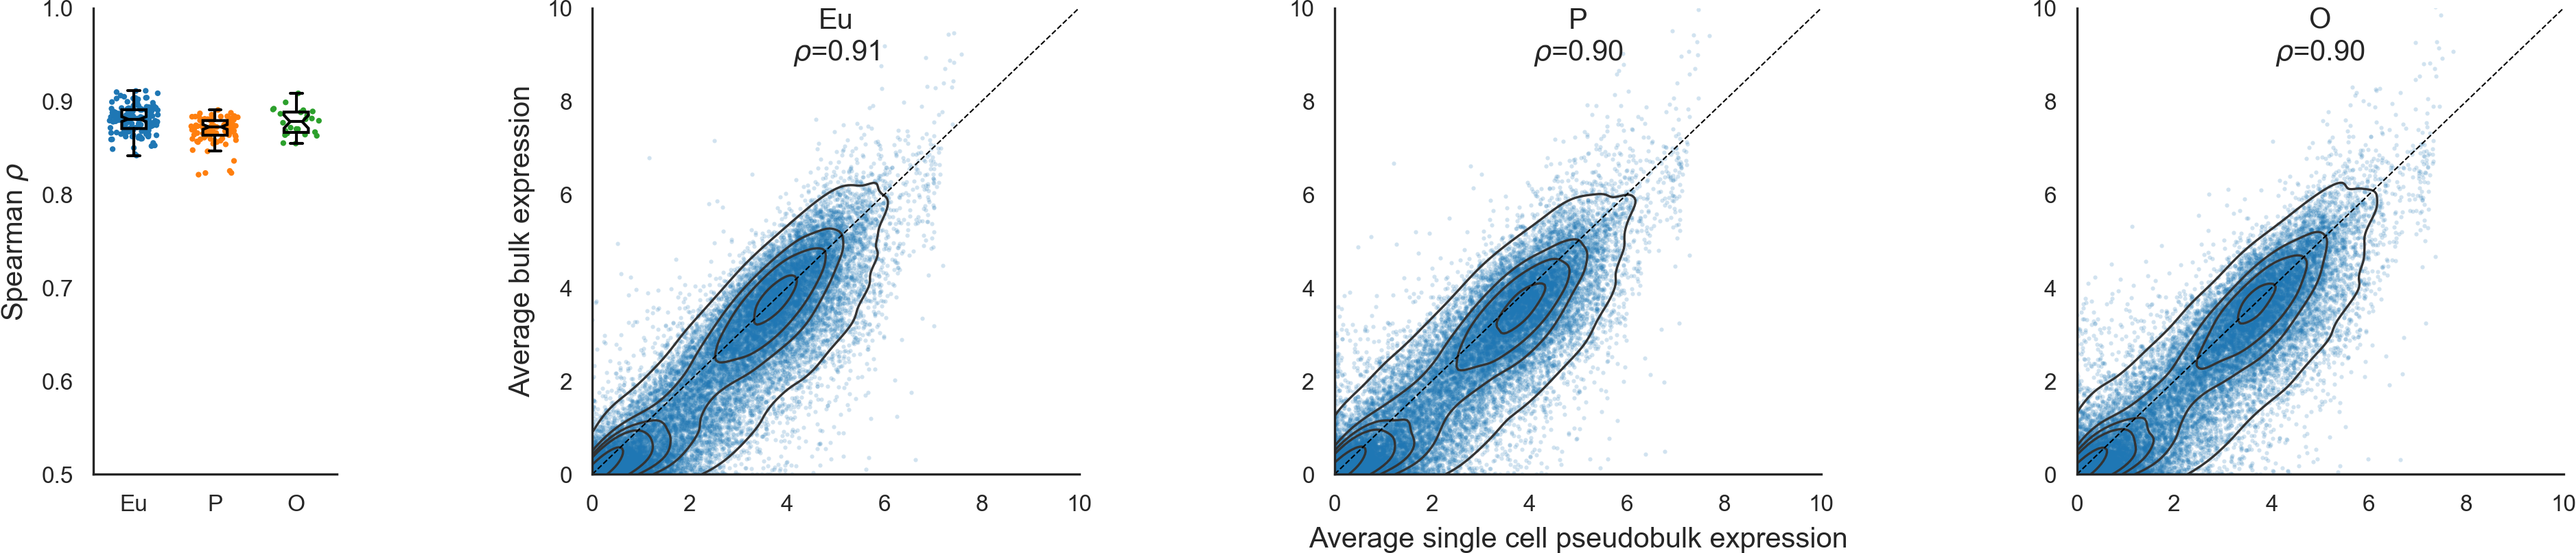

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4, figsize=(12, 3), gridspec_kw={"width_ratios":[0.5, 1, 1, 1], "wspace":0.6}
)

scatter_params = dict(marker=".", s=1, alpha=0.2, rasterized=True)
kde_params = dict(fill=False, levels=6, linewidths=0.8, color="0.2", alpha=1)
strip_params = dict(size=2, jitter=0.3, zorder=-20)
box_params = dict(
    width=0.3, sym="", linewidth=1, color="white", notch=True, 
    boxprops={"facecolor": "none", "edgecolor": "k"},
    medianprops={"color": "k"}, capprops={"color": "k"}, whiskerprops={"color": "k"}
)

sns.stripplot(data=vio_data, x="location", y="val", ax=ax1, **strip_params)
sns.boxplot(data=vio_data, x="location", y="val", ax=ax1, **box_params)

ax1.set_ylim(0.5, 1)
ax1.set_xlabel("")
ax1.set_ylabel(r"Spearman $\rho$")
sns.despine(fig)

for k, (ax, st) in enumerate(zip((ax2, ax3, ax4), sample_types)):
    idx_st = combined_bulk.obs.sample_location.isin([st])
    idx_bulk = combined_bulk.obs.method.isin(["single_cell"])
    
    x = np.log1p(combined_bulk[idx_st & idx_bulk].X.mean(axis=0))
    y = np.log1p(combined_bulk[idx_st & ~idx_bulk].X.mean(axis=0))
    ax.scatter(x, y, **scatter_params)
    
    if True:
        sns.kdeplot(x, y, ax=ax, **kde_params)
        
    ax.plot([0,10], [0, 10], "k--", lw=0.5)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if k == 0:
        ax.set_ylabel("Average bulk expression")
    if k == 1:
        ax.set_xlabel("Average single cell pseudobulk expression")
    ax.text(0.5, 1, f"{st}\n"+rf"$\rho$={mean_corrs[st]:.2f}", ha="center", va="top", transform=ax.transAxes)

In [22]:
fig.savefig(f"{fig_dir}/bulk-vs-sc.pdf")